In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
8,159 cases (7 day average) as of Sat 19 Jun, +246.3 since Fri 18 Jun
182 hospitalised (7 day average) as of Tue 22 Jun, -0.9 since Mon 21 Jun
10 died (7 day average) as of Sat 19 Jun, +0.4 since Fri 18 Jun


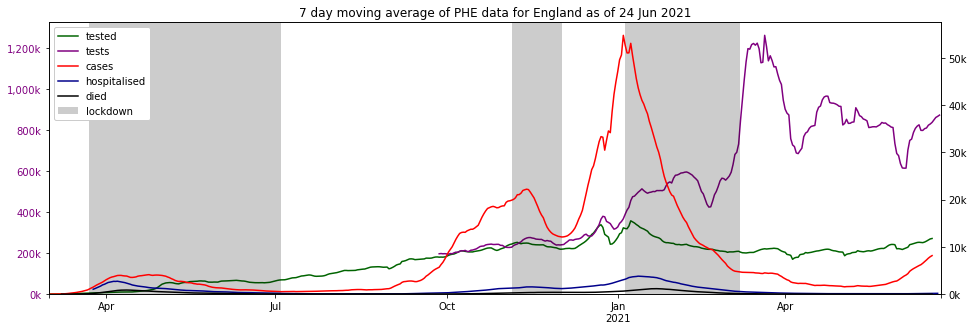

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

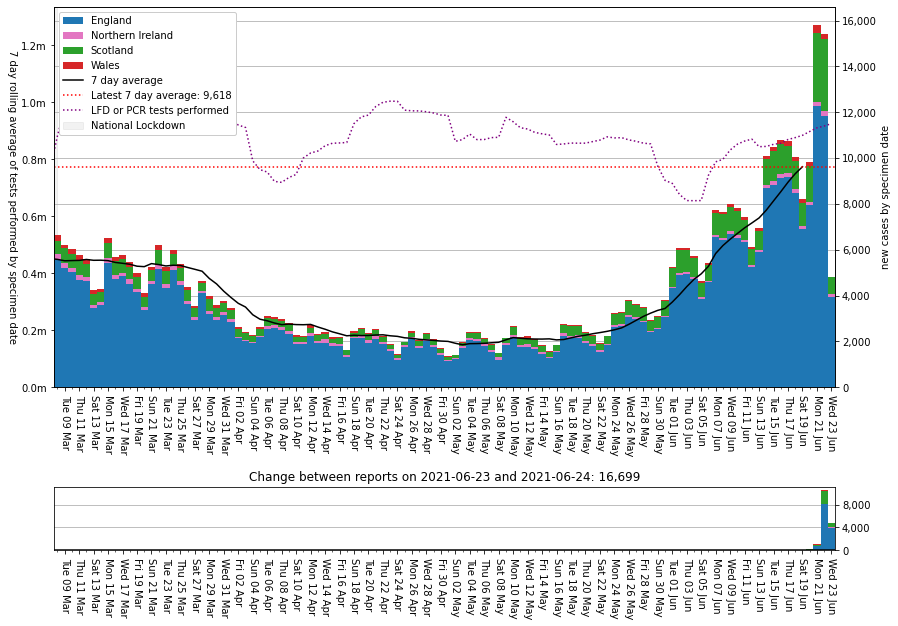

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

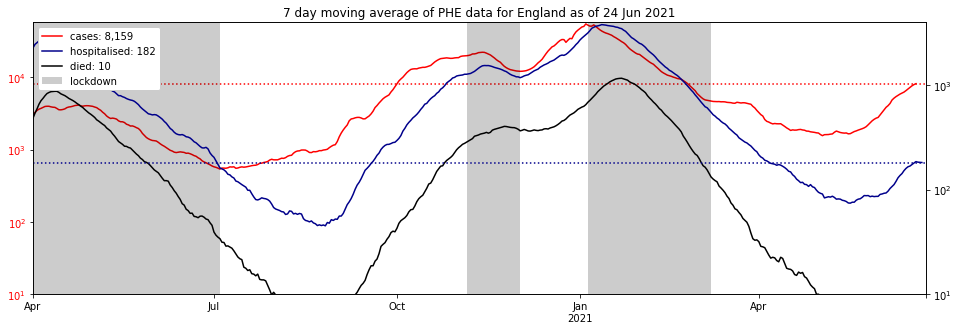

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

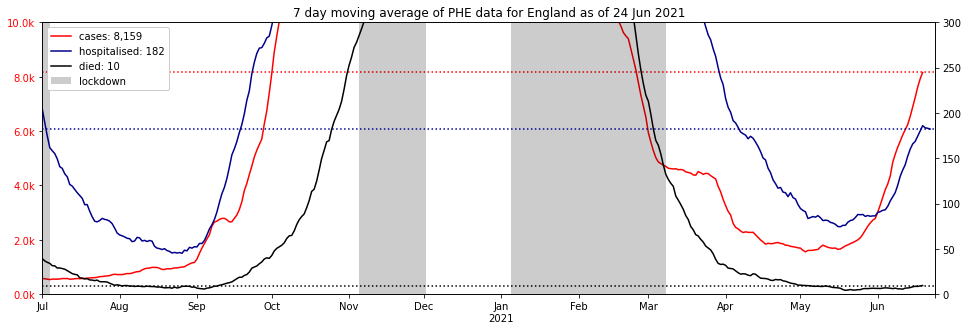

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=10_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=300)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,23 Jun 21,"+26,874,354","+36,564,938","+26,874,354","+128,688","+187,513","+128,688"
Northern Ireland,23 Jun 21,"+830,506","+1,150,202","+830,506","+6,598","+3,049","+6,598"
Scotland,23 Jun 21,"+2,631,533","+3,695,303","+2,631,533","+14,083","+13,683","+14,083"
Wales,23 Jun 21,"+1,571,710","+2,245,884","+1,571,710","+18,619","+3,402","+18,619"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,26874354.0,36564938.0,9690584.0,56286961,47.745257,17.216392,35.038351
1,Northern Ireland,N92000002,830506.0,1150202.0,319696.0,1893667,43.857024,16.882377,39.260599
2,Scotland,S92000003,2631533.0,3695303.0,1063770.0,5463300,48.167463,19.471199,32.361338
3,Wales,W92000004,1571710.0,2245884.0,674174.0,3152879,49.849994,21.382806,28.767200


'partial: 43,656,327 (65.4%), full: 31,908,103'

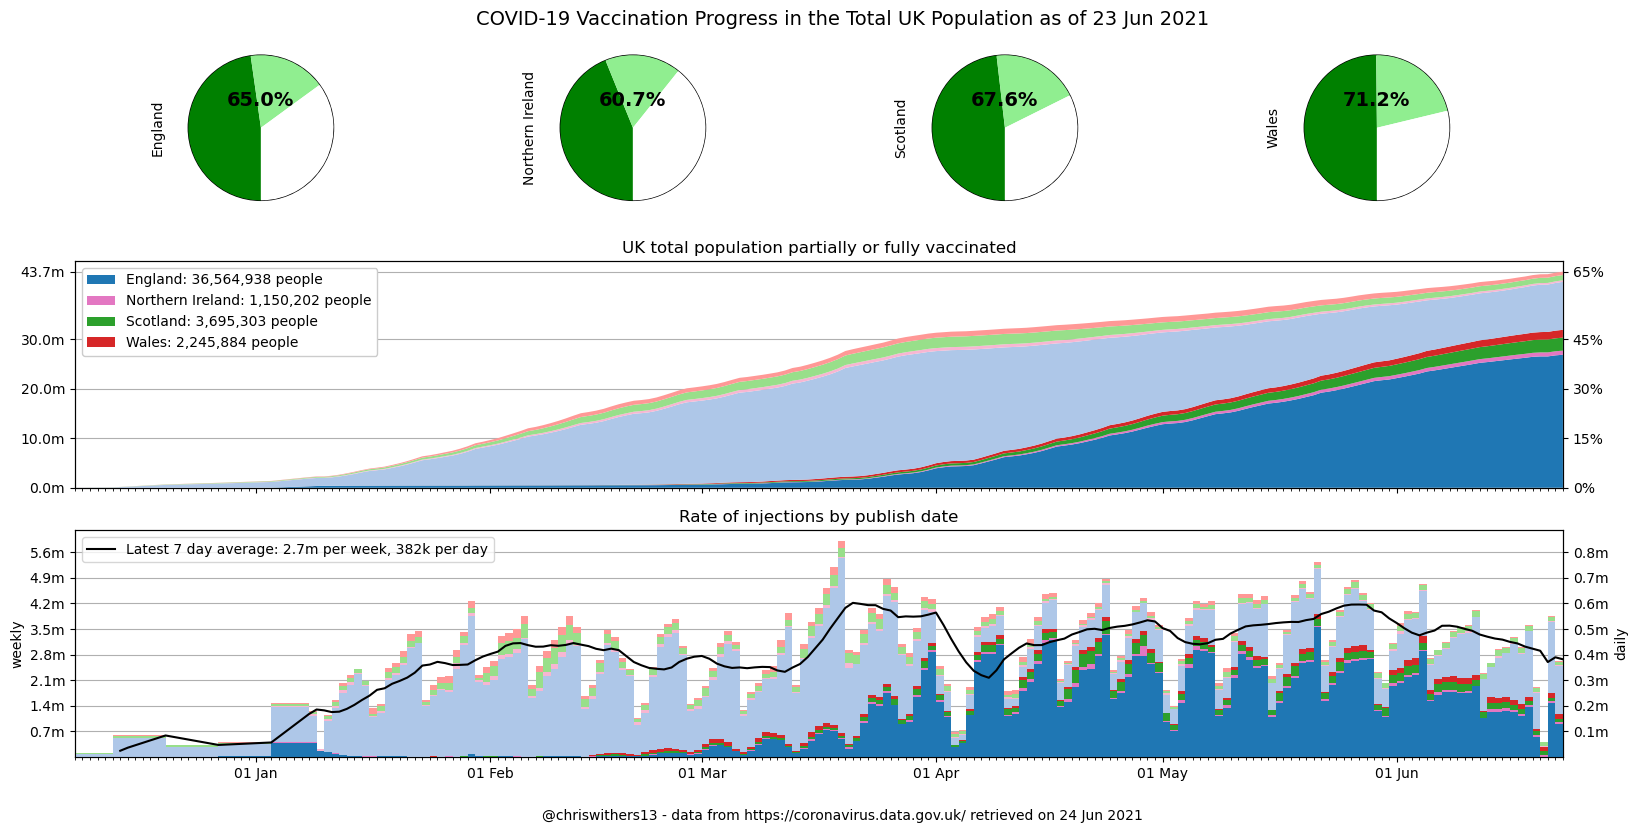

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

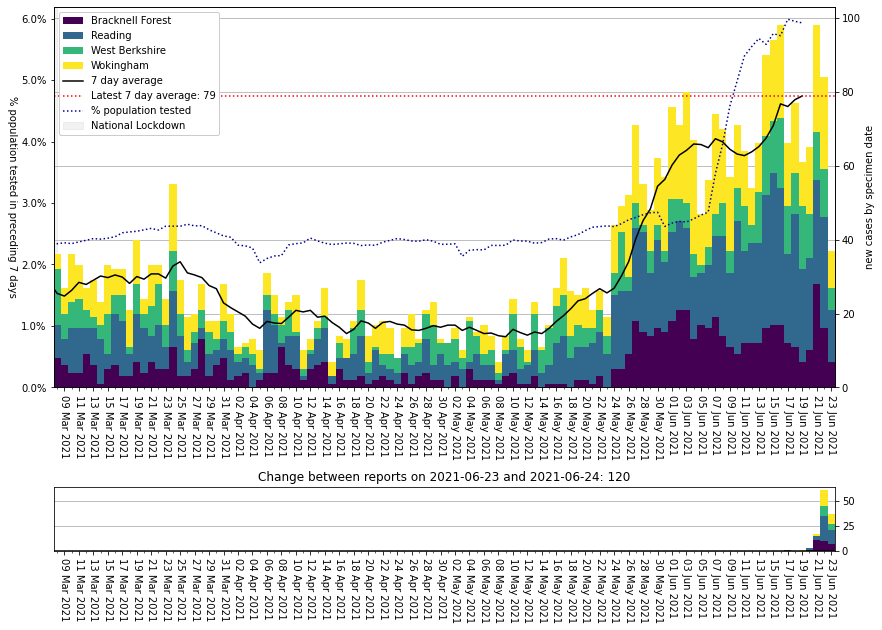

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], lines=unique_people_tested)

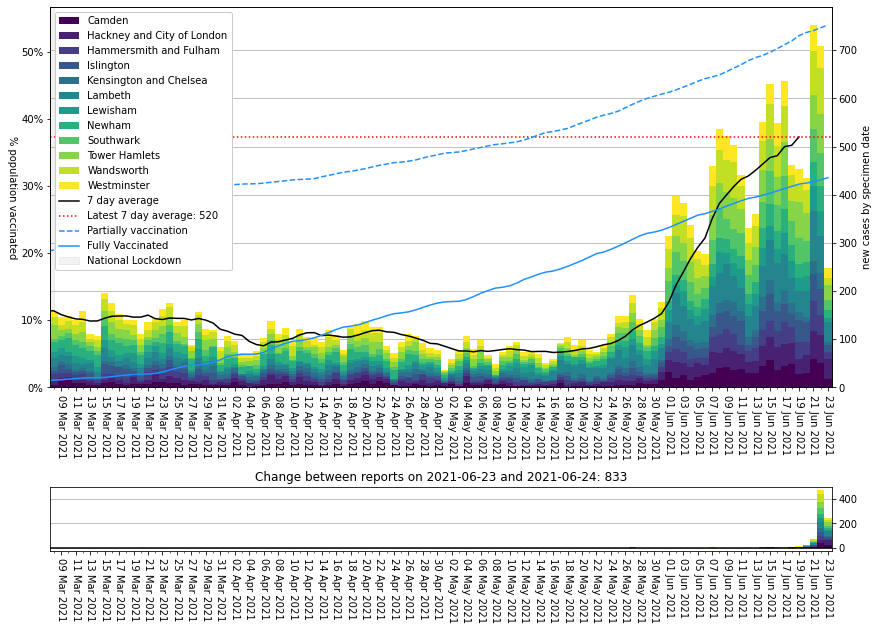

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [20]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000010,East Lothian,466.897003,500.0,2021-06-23
E07000120,Hyndburn,449.144281,364.0,2021-06-23
S12000042,Dundee City,430.618805,643.0,2021-06-23
E06000008,Blackburn with Darwen,409.496580,613.0,2021-06-23
S12000036,City of Edinburgh,377.002648,1979.0,2021-06-23
S12000019,Midlothian,368.808133,341.0,2021-06-23
E08000003,Manchester,359.586006,1988.0,2021-06-23
E07000117,Burnley,340.755735,303.0,2021-06-23
E07000125,Rossendale,337.147813,241.0,2021-06-23


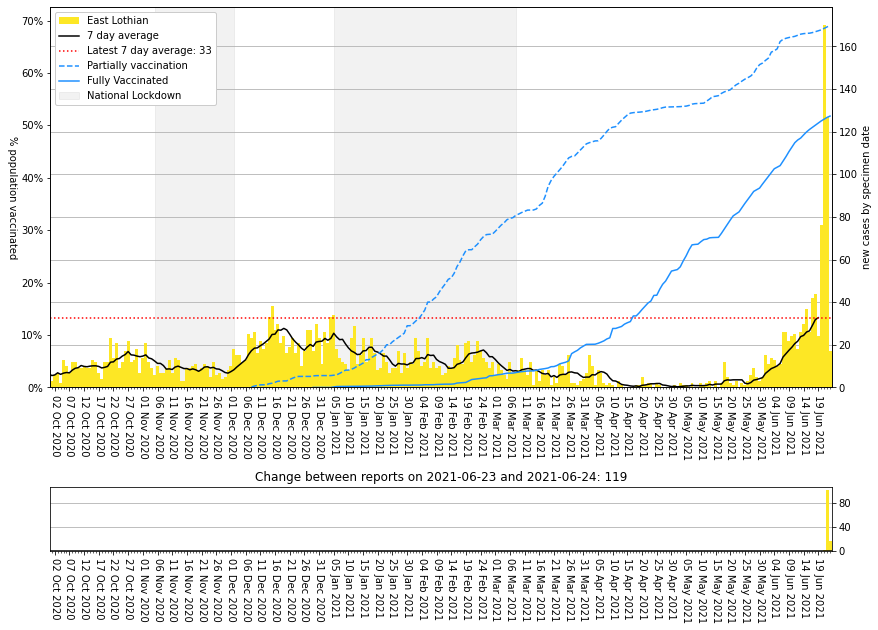

In [21]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=population_vaccinated)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000003,Manchester,359.586006,1988.0,2021-06-23
S12000036,City of Edinburgh,377.002648,1979.0,2021-06-23
E08000035,Leeds,241.823943,1918.0,2021-06-23
E08000025,Birmingham,130.756619,1493.0,2021-06-23
S12000049,Glasgow City,226.813242,1436.0,2021-06-23
E06000047,County Durham,252.219418,1337.0,2021-06-23
E08000012,Liverpool,266.041820,1325.0,2021-06-23
E08000021,Newcastle upon Tyne,323.954825,981.0,2021-06-23
E08000010,Wigan,295.744564,972.0,2021-06-23


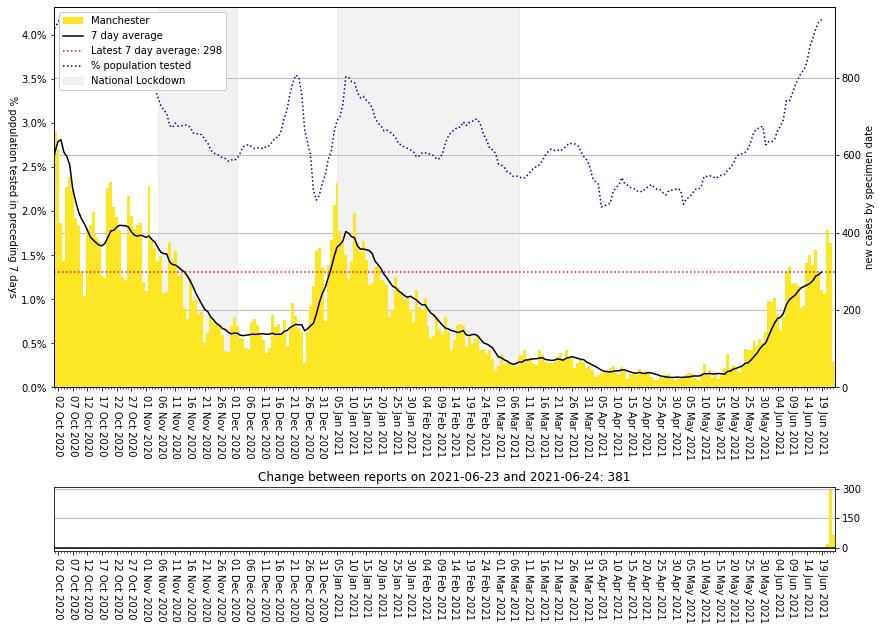

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 2.5
phe_max = 0.5

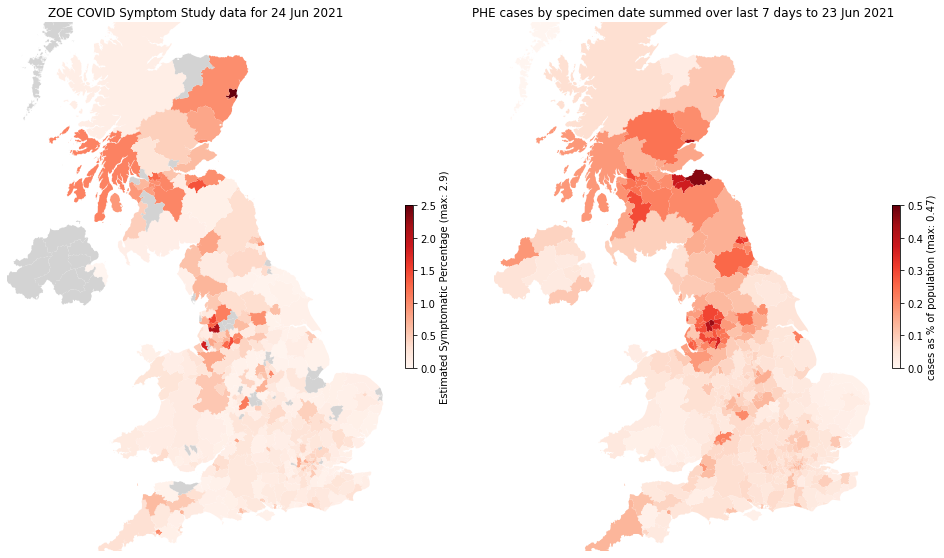

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...